## Overview:
My mini-project involves crawling and extracting data from the BBC News website for analysis. I selected the BBC News website because it is a webpage that can be adequately crawled using Beautiful Soup and regularly updates a diverse range of text data. Lastly, the site lacks its own statistical analysis UI, allowing me to explore various analyses without imitation.

Articles on the BBC webpage are freely available for the latest articles. Since these recent articles are limited to about 12 pages per continent, I selected news from Europe, Africa, Asia, and North America. This results in approximately 48 pages of data, with each page containing about 9-10 articles.

Using this data, I conducted sentiment analysis, named entity recognition (NER), and noun word analysis on the articles. Each analysis utilized pie charts, bar charts, and word cloud visualizations.

Specific Libraries Used:
textblob (not used due to performance issues): A simple library for text data sentiment analysis and language processing.
vaderSentiment: A sentiment analysis tool specialized for social media text.
seaborn: A Python library for statistical data visualization.
spacy: An industrial-strength Python library for fast natural language processing.
WordCloud: A visualization tool for generating word clouds from text data.

## Code Explanation:

#### Data Extraction:

Step 1:
Use Beautiful Soup to perform the first extraction from the BBC homepage. This initial extraction aims to collect the title, link, and publication date of all articles in the news section. After extracting all pages, I used the find method within the code to extract specific elements. These elements were stored in the news_data list. The process was repeated using pagination code, and the final data was converted into a DataFrame and saved as a CSV file.

Step 2:
Using the CSV file saved in Step 1, this code aims to collect the actual article content for each article. Using the saved links from Step 1, I accessed each link and used the get_article_details function to extract detailed text from the articles. The extracted content was then converted into a DataFrame and saved as a CSV file.

#### Data Analysis:
Step 1:
The first step in data analysis is sentiment analysis and visualization. I initially tried using textblob, but due to its low performance, I opted for vaderSentiment and used threshold values determined through experimentation. The analyze_sentiment function uses vaderSentiment, and I used the file saved from Step 2 of data extraction along with this function to produce the results. The resulting values were calculated as ratios and visualized using an sns pie chart.

Step 2:
First, I loaded the spacy library, which can perform tokenization and part-of-speech tagging for English models, and stored it in the nlp variable. I created the extract_countries function, where 'GPE' is a label representing countries, cities, and locations. Finally, using a for loop, I applied this function to the data in the loaded CSV file, produced the results, and visualized the top 7 countries using an sns bar chart.

Step 3:
Similar to Step 2, I loaded the spacy object and set the token_pos value to "NOUN" to extract nouns from the text, with the noun length restricted to 3 characters or more. Using the Python standard library Counter, I calculated the frequency. To aggregate the data, I calculated the ratio of each word, extracted the top 50 words, and stored them as a dictionary. Finally, I visualized the results using the WordCloud library.

## Results:
The visualizations created effectively explain the current topics of interest for each continent. For example, France is currently in a state of confusion due to the elections. On the day the data was extracted from the BBC, the left and centrist parties overturned the right-wing party in the second election in France. This was a significant event not only in France but throughout Europe, and it was covered extensively by the media. The named entity recognition (NER) visualization also reflected this well, with France and Paris being prominently featured. Sentiment analysis of the articles showed that Europe had a high proportion of positive sentiments. This can be interpreted as the BBC articles covering the French issue positively. The most dominant nouns were "people," "election," and "alliance," which also reflect the current situation in Europe. Other continents also had notable data reflecting the current issues, and the word cloud analysis for all continents showed that "People" was the most significant issue globally. I believe the most important thing is always the people themselves.

# Europe

In [41]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

# BBC URL
base_url = "https://www.bbc.com/news/world/europe"

def get_articles_from_page(url):
    response = requests.get(url)
    response.raise_for_status() 
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract articles
    articles = soup.find_all('div', {'data-testid': 'liverpool-card'})
    news_data = []

    for article in articles:
        title_tag = article.find('h2', {'data-testid': 'card-headline'})
        link_tag = article.find('a', {'data-testid': 'internal-link'})
        date_tag = article.find('span', {'data-testid': 'card-metadata-lastupdated'})

        if title_tag and link_tag: # extract articles(url)
            title = title_tag.text.strip()
            link = "https://www.bbc.com" + link_tag['href']
            date = date_tag.text.strip() if date_tag else None
            
            news_data.append({'title': title, 'link': link, 'date': date})

    return news_data

# pagination
news_data = []
for page in range(1, 13):  # the maximum page number is 12 in the web  
    page_url = base_url + f"?page={page}"
    news_data.extend(get_articles_from_page(page_url))

# to the dataframe
df = pd.DataFrame(news_data)
df.to_csv('bbc_europe.csv', index=False)

print("First phase completed")


First phase completed


In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# load data from the previous CSV file
df = pd.read_csv('bbc_europe.csv')

# article body extracting function
def get_article_details(url):
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, 'html.parser')

    paragraphs = soup.find_all('div', {'data-component': 'text-block'})
    body = ' '.join(p.get_text(separator=' ', strip=True) for p in paragraphs)
    
    return body

# save the body
detailed_news_data = []

for index, row in df.iterrows():
    try:
        body = get_article_details(row['link'])
        detailed_news_data.append({
            'title': row['title'],
            'link': row['link'],
            'date': row['date'],
            'body': body
        })
    except Exception as e:
        print(f"Error processing article at {row['link']}: {e}")

# dataframe
detailed_df = pd.DataFrame(detailed_news_data)
detailed_df.to_csv('bbc_detailed_europe.csv', index=False)

print("Second phase completed")


Second phase completed


Articles and sentiment analysis results:
                                                 title        date sentiment
0    Children's hospital hit as Russian strikes kil...    Just now  Negative
1        Second elephant dies from virus at Dublin Zoo   2 hrs ago  Positive
2         Villages to celebrate 60 years of friendship   4 hrs ago  Positive
3    Donegal team take inaugural Down’s syndrome cu...   5 hrs ago  Positive
4       What just happened in France's shock election?   9 hrs ago  Positive
..                                                 ...         ...       ...
103     What just happened in France's shock election?   9 hrs ago  Positive
104  French left celebrates as far right faces surp...  10 hrs ago  Positive
105  Euphoria and rage in Bordeaux over shock poll ...  12 hrs ago  Positive
106  Jubilation and stunned silence: France reacts ...  13 hrs ago   Neutral
107  'Victims of a dishonest alliance': French far ...  13 hrs ago  Positive

[108 rows x 3 columns]


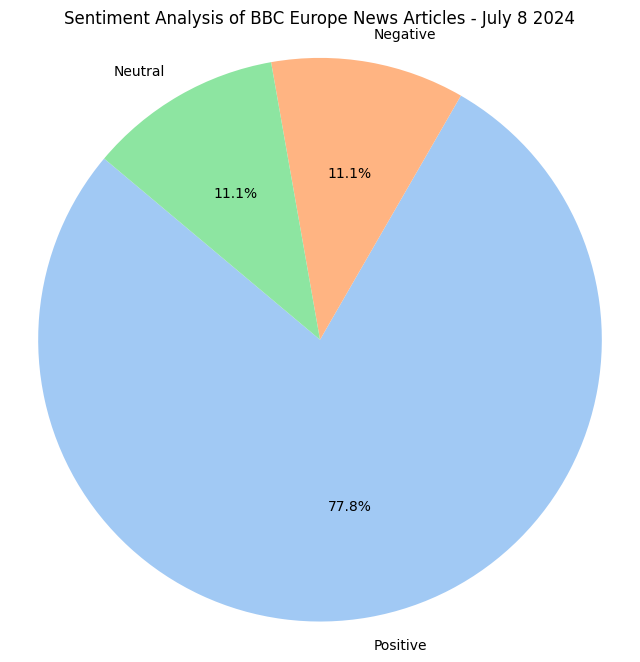

In [16]:
# Data analysis & Viz 1

from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# load the detailed CSV file
df = pd.read_csv('bbc_detailed_europe.csv')

# VADER Analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis function
def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] > 0.2:
        return 'Positive'
    elif scores['compound'] < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

df['body'] = df['body'].fillna('')    
    
# Perform sentiment analysis on each article body
df['sentiment'] = df['body'].apply(analyze_sentiment)

print("Articles and sentiment analysis results:")
print(df[['title', 'date', 'sentiment']])

# Calculate sentiment analysis result ratio
sentiment_counts = df['sentiment'].value_counts(normalize=True)

# color change
pastel_colors = sns.color_palette("pastel")

# vizualiztion pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, colors=pastel_colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Analysis of BBC Europe News Articles - July 8 2024')
plt.axis('equal')  # keep circle 
plt.show()


Countries most mentioned in articles:
France     360
Russia      84
Ukraine     72
Paris       48
Héry        36
UK          24
Ireland     24
Name: count, dtype: int64


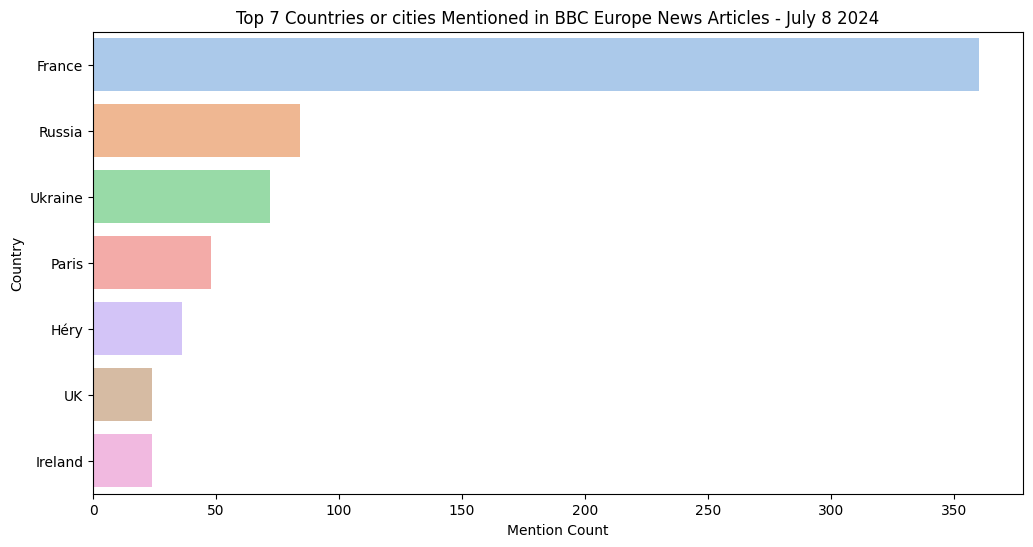

In [17]:
# Data analysis & Viz 2

import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# spaCy English model
nlp = spacy.load('en_core_web_sm')

# load the detailed CSV file
df = pd.read_csv('bbc_detailed_europe.csv')
df['body'] = df['body'].fillna('')

# Extract country name 
def extract_countries(text):
    doc = nlp(text)
    countries = [ent.text for ent in doc.ents if ent.label_ == 'GPE']  
    return countries

all_countries = []

for index, row in df.iterrows():
    try:
        countries = extract_countries(row['body'])
        all_countries.extend(countries)
    except Exception as e:
        print(f"Error processing article at {row['link']}: {e}")

# Ratio
country_counts = pd.Series(all_countries).value_counts()

print("Countries most mentioned in articles:")
print(country_counts.head(7))

top_countries = country_counts.head(7)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='pastel')
plt.title('Top 7 Countries or cities Mentioned in BBC Europe News Articles - July 8 2024')
plt.xlabel('Mention Count')
plt.ylabel('Country')
plt.show()


<Top 50 Most Dominant Nouns in Europe>

people: 240, Ratio: 2.13%
alliance: 180, Ratio: 1.60%
election: 168, Ratio: 1.49%
hospital: 156, Ratio: 1.38%
power: 156, Ratio: 1.38%
right: 144, Ratio: 1.28%
party: 144, Ratio: 1.28%
voters: 144, Ratio: 1.28%
elephants: 132, Ratio: 1.17%
time: 132, Ratio: 1.17%
parliament: 132, Ratio: 1.17%
victory: 120, Ratio: 1.06%
president: 120, Ratio: 1.06%
round: 108, Ratio: 0.96%
virus: 108, Ratio: 0.96%
wing: 96, Ratio: 0.85%
part: 84, Ratio: 0.74%
seats: 84, Ratio: 0.74%
candidates: 84, Ratio: 0.74%
government: 84, Ratio: 0.74%
missile: 72, Ratio: 0.64%
year: 72, Ratio: 0.64%
elephant: 72, Ratio: 0.64%
zoo: 72, Ratio: 0.64%
minister: 72, Ratio: 0.64%
left: 72, Ratio: 0.64%
supporters: 72, Ratio: 0.64%
vote: 72, Ratio: 0.64%
children: 60, Ratio: 0.53%
air: 60, Ratio: 0.53%
response: 60, Ratio: 0.53%
place: 60, Ratio: 0.53%
way: 60, Ratio: 0.53%
players: 60, Ratio: 0.53%
majority: 60, Ratio: 0.53%
mps: 60, Ratio: 0.53%
candidate: 60, Ratio: 0.53%
morning

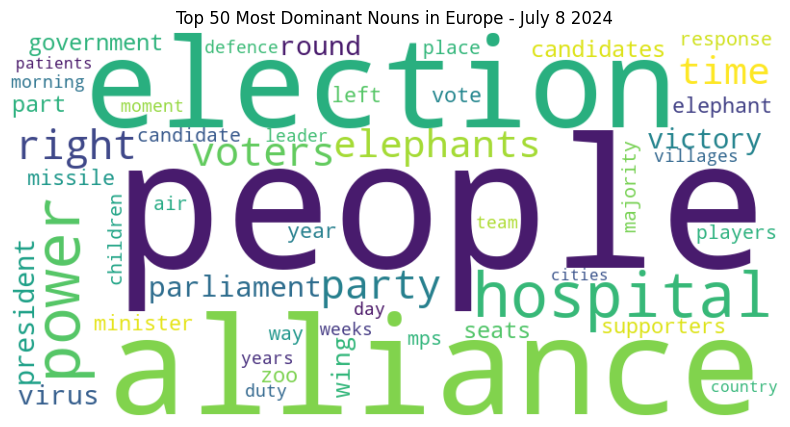

In [5]:
# Data analysis & Viz 3

from collections import Counter
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# spaCy English model
nlp = spacy.load('en_core_web_sm')

# load the detailed CSV file
df = pd.read_csv('bbc_detailed_europe.csv')

# concatenate all articles
all_text = ' '.join(df['body'].dropna())

# Convert all text to spaCy object
doc = nlp(all_text)

# Extracts only nouns and includes only words with 3 or more letters
nouns = [token.text.lower() for token in doc if token.pos_ == 'NOUN' and len(token.text) >= 3]

# Word frequency calculation
word_counts = Counter(nouns)

# Ratio
total_nouns = sum(word_counts.values())
word_ratios = {word: count / total_nouns for word, count in word_counts.items()}

# Extract the top 50 most used words
most_common_words = word_counts.most_common(50)

# Rario on top 50
most_common_ratios = [(word, count, word_ratios[word]) for word, count in most_common_words]
word_freq = {word: count for word, count in most_common_words}

# Print Result
print("<Top 50 Most Dominant Nouns in Europe>")
print()
for word, count, ratio in most_common_ratios:
    print(f"{word}: {count}, Ratio: {ratio:.2%}")

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Most Dominant Nouns in Europe - July 8 2024')
plt.show()


# Asia

In [17]:
# BBC URL
base_url = "https://www.bbc.com/news/world/asia"

def get_articles_from_page(url):
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract articles
    articles = soup.find_all('div', {'data-testid': 'liverpool-card'})
    news_data = []

    for article in articles:
        title_tag = article.find('h2', {'data-testid': 'card-headline'})
        link_tag = article.find('a', {'data-testid': 'internal-link'})
        date_tag = article.find('span', {'data-testid': 'card-metadata-lastupdated'})

        if title_tag and link_tag: # extract articles(url)
            title = title_tag.text.strip()
            link = "https://www.bbc.com" + link_tag['href']
            date = date_tag.text.strip() if date_tag else None
            
            news_data.append({'title': title, 'link': link, 'date': date})

    return news_data

# pagination
news_data = []
for page in range(1, 13):  # the maximum page number is 12 in the web  
    page_url = base_url + f"?page={page}"
    news_data.extend(get_articles_from_page(page_url))

# to the dataframe
df = pd.DataFrame(news_data)
df.to_csv('bbc_asia.csv', index=False)

print("First phase completed")

First phase completed


In [7]:
# load data from the previous CSV file
df = pd.read_csv('bbc_asia.csv')

# article body extracting function
def get_article_details(url):
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, 'html.parser')

    paragraphs = soup.find_all('div', {'data-component': 'text-block'})
    body = ' '.join(p.get_text(separator=' ', strip=True) for p in paragraphs)
    
    return body

# save the body
detailed_news_data = []

for index, row in df.iterrows():
    try:
        body = get_article_details(row['link'])
        detailed_news_data.append({
            'title': row['title'],
            'link': row['link'],
            'date': row['date'],
            'body': body
        })
    except Exception as e:
        print(f"Error processing article at {row['link']}: {e}")

# dataframe
detailed_df = pd.DataFrame(detailed_news_data)
detailed_df.to_csv('bbc_detailed_asia.csv', index=False)

print("Second phase completed")

Second phase completed


Articles and sentiment analysis results:
                                                 title        date sentiment
0        Floods kill six rhinos in India national park   6 hrs ago  Negative
1     India event organiser arrested after fatal crush   9 hrs ago  Negative
2     Massive floods affect millions across South Asia  11 hrs ago  Negative
3    After Covid and Olympics, Tokyo’s first female...  15 hrs ago  Positive
4     How fetching water is holding back India's women  17 hrs ago  Positive
..                                                 ...         ...       ...
103   How fetching water is holding back India's women  17 hrs ago  Positive
104     Kimchi blamed for mass sickness in South Korea  2 days ago  Negative
105  Debris flies through air as tornado hits China...  3 days ago   Neutral
106       India preacher denies blame for crush deaths  4 days ago  Negative
107    India's X alternative Koo to shut down services  4 days ago  Negative

[108 rows x 3 columns]


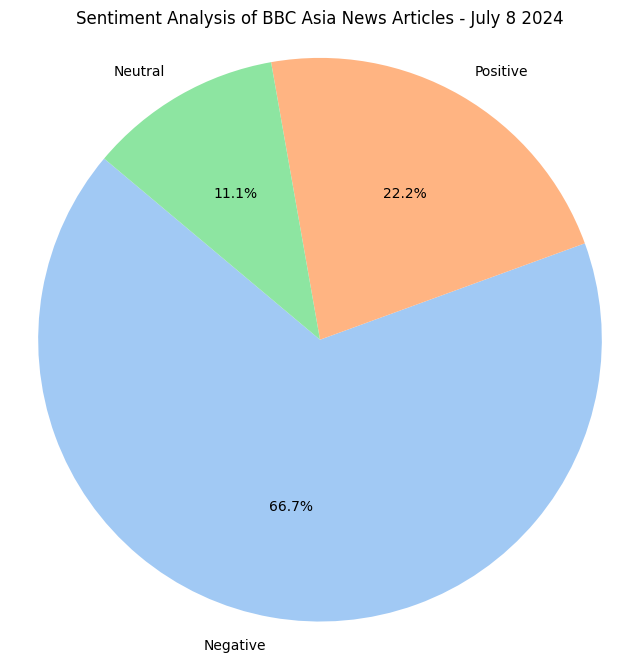

In [6]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# load the detailed CSV file
df = pd.read_csv('bbc_detailed_asia.csv')

# VADER Analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis function
def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] > 0.2:
        return 'Positive'
    elif scores['compound'] < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

df['body'] = df['body'].fillna('')    
    
# Perform sentiment analysis on each article body
df['sentiment'] = df['body'].apply(analyze_sentiment)

print("Articles and sentiment analysis results:")
print(df[['title', 'date', 'sentiment']])

# Calculate sentiment analysis result ratio
sentiment_counts = df['sentiment'].value_counts(normalize=True)

# color change
pastel_colors = sns.color_palette("pastel")

# vizualiztion pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, colors=pastel_colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Analysis of BBC Asia News Articles - July 8 2024')
plt.axis('equal')  # keep circle 
plt.show()


Countries most mentioned in articles:
India          324
Tokyo          156
Nepal           36
Bangladesh      36
Japan           36
Tringalwadi     24
Mumbai          24
Name: count, dtype: int64


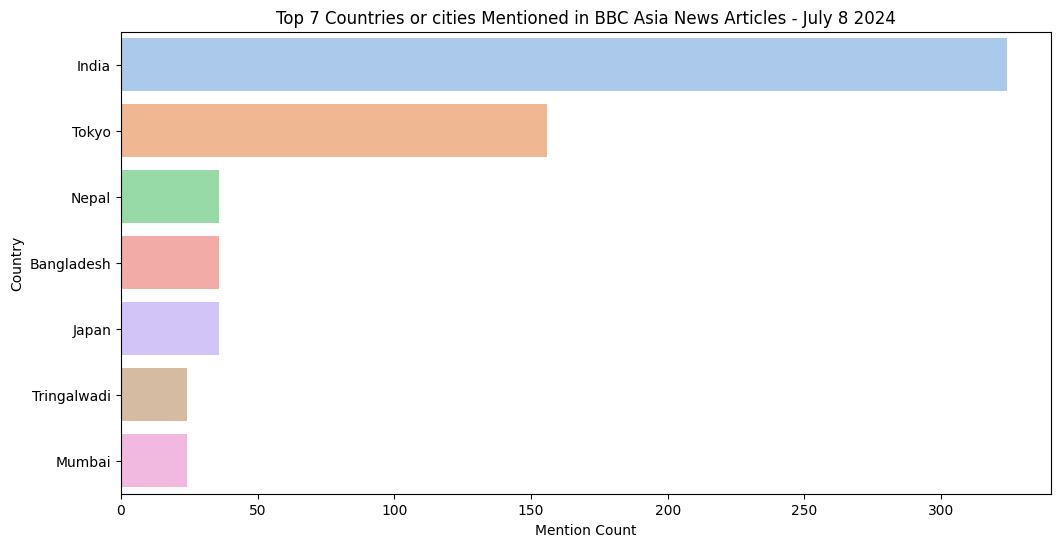

In [7]:
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# spaCy English model
nlp = spacy.load('en_core_web_sm')

# load the detailed CSV file
df = pd.read_csv('bbc_detailed_asia.csv')
df['body'] = df['body'].fillna('')

# Extract country name 
def extract_countries(text):
    doc = nlp(text)
    countries = [ent.text for ent in doc.ents if ent.label_ == 'GPE']  
    return countries

all_countries = []

for index, row in df.iterrows():
    try:
        countries = extract_countries(row['body'])
        all_countries.extend(countries)
    except Exception as e:
        print(f"Error processing article at {row['link']}: {e}")

# Ratio
country_counts = pd.Series(all_countries).value_counts()

print("Countries most mentioned in articles:")
print(country_counts.head(7))

top_countries = country_counts.head(7)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='pastel')
plt.title('Top 7 Countries or cities Mentioned in BBC Asia News Articles - July 8 2024')
plt.xlabel('Mention Count')
plt.ylabel('Country')
plt.show()

<Top 50 Most Dominant Nouns in Asia>

water: 444, Ratio: 3.73%
people: 336, Ratio: 2.83%
women: 216, Ratio: 1.82%
police: 192, Ratio: 1.61%
officials: 144, Ratio: 1.21%
year: 132, Ratio: 1.11%
village: 108, Ratio: 0.91%
days: 96, Ratio: 0.81%
news: 96, Ratio: 0.81%
floods: 84, Ratio: 0.71%
preacher: 84, Ratio: 0.71%
term: 84, Ratio: 0.71%
election: 84, Ratio: 0.71%
city: 84, Ratio: 0.71%
media: 84, Ratio: 0.71%
animals: 72, Ratio: 0.61%
park: 72, Ratio: 0.61%
years: 72, Ratio: 0.61%
crush: 72, Ratio: 0.61%
country: 72, Ratio: 0.61%
event: 72, Ratio: 0.61%
investigation: 72, Ratio: 0.61%
day: 72, Ratio: 0.61%
rhinos: 60, Ratio: 0.50%
rivers: 60, Ratio: 0.50%
state: 60, Ratio: 0.50%
lawyer: 60, Ratio: 0.50%
report: 60, Ratio: 0.50%
millions: 60, Ratio: 0.50%
authorities: 60, Ratio: 0.50%
number: 60, Ratio: 0.50%
work: 60, Ratio: 0.50%
government: 60, Ratio: 0.50%
flooding: 48, Ratio: 0.40%
rains: 48, Ratio: 0.40%
thousands: 48, Ratio: 0.40%
roads: 48, Ratio: 0.40%
hundreds: 48, Ratio: 0.

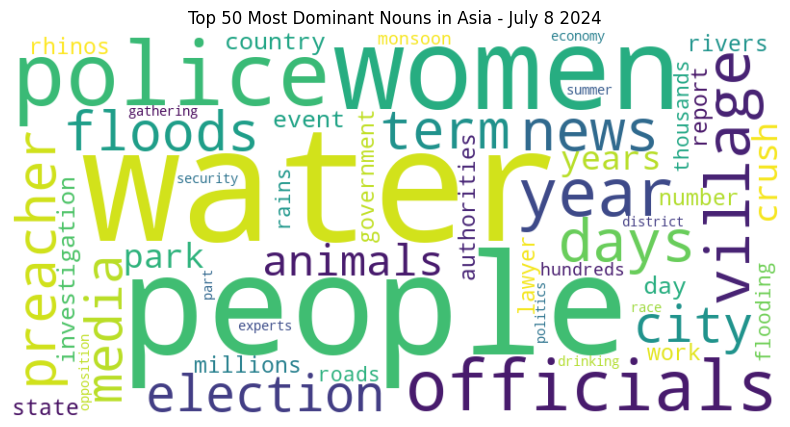

In [8]:
from collections import Counter
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# spaCy English model
nlp = spacy.load('en_core_web_sm')

# load the detailed CSV file
df = pd.read_csv('bbc_detailed_asia.csv')

# concatenate all articles
all_text = ' '.join(df['body'].dropna())

# Convert all text to spaCy object
doc = nlp(all_text)

# Extracts only nouns and includes only words with 3 or more letters
nouns = [token.text.lower() for token in doc if token.pos_ == 'NOUN' and len(token.text) >= 3]

# Word frequency calculation
word_counts = Counter(nouns)

# Ratio
total_nouns = sum(word_counts.values())
word_ratios = {word: count / total_nouns for word, count in word_counts.items()}

# Extract the top 50 most used words
most_common_words = word_counts.most_common(50)

# Rario on top 50
most_common_ratios = [(word, count, word_ratios[word]) for word, count in most_common_words]
word_freq = {word: count for word, count in most_common_words}

# Print Result
print("<Top 50 Most Dominant Nouns in Asia>")
print()
for word, count, ratio in most_common_ratios:
    print(f"{word}: {count}, Ratio: {ratio:.2%}")

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Most Dominant Nouns in Asia - July 8 2024')
plt.show()

# Africa

In [72]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

# BBC URL
base_url = "https://www.bbc.com/news/world/africa"

def get_articles_from_page(url):
    response = requests.get(url)
    response.raise_for_status() 
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract articles
    articles = soup.find_all('div', {'data-testid': 'liverpool-card'})
    news_data = []

    for article in articles:
        title_tag = article.find('h2', {'data-testid': 'card-headline'})
        link_tag = article.find('a', {'data-testid': 'internal-link'})
        date_tag = article.find('span', {'data-testid': 'card-metadata-lastupdated'})

        if title_tag and link_tag: # extract articles(url)
            title = title_tag.text.strip()
            link = "https://www.bbc.com" + link_tag['href']
            date = date_tag.text.strip() if date_tag else None
            
            news_data.append({'title': title, 'link': link, 'date': date})

    return news_data

# pagination
news_data = []
for page in range(1, 12):  # the maximum page number is 11 in the web  
    page_url = base_url + f"?page={page}"
    news_data.extend(get_articles_from_page(page_url))

# to the dataframe
df = pd.DataFrame(news_data)
df.to_csv('bbc_africa.csv', index=False)

print("First phase completed")

First phase completed


In [9]:
# load data from the previous CSV file
df = pd.read_csv('bbc_africa.csv')

# article body extracting function
def get_article_details(url):
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, 'html.parser')

    paragraphs = soup.find_all('div', {'data-component': 'text-block'})
    body = ' '.join(p.get_text(separator=' ', strip=True) for p in paragraphs)
    
    return body

# save the body
detailed_news_data = []

for index, row in df.iterrows():
    try:
        body = get_article_details(row['link'])
        detailed_news_data.append({
            'title': row['title'],
            'link': row['link'],
            'date': row['date'],
            'body': body
        })
    except Exception as e:
        print(f"Error processing article at {row['link']}: {e}")

# dataframe
detailed_df = pd.DataFrame(detailed_news_data)
detailed_df.to_csv('bbc_detailed_africa.csv', index=False)

print("Second phase completed")


Second phase completed


Articles and sentiment analysis results:
                                                title        date sentiment
0   UK looking at what money can be recouped from ...    1 hr ago  Negative
1     South African football star held up at gunpoint   2 hrs ago  Positive
2           Liberian president cuts his salary by 40%   2 hrs ago  Positive
3   West African bloc risks 'disintegration' if ju...   4 hrs ago  Negative
4        Accused of witchcraft then murdered for land  16 hrs ago  Negative
..                                                ...         ...       ...
94       Accused of witchcraft then murdered for land  16 hrs ago  Negative
95  Forget Ethiopia's Spice Girls - this singer sa...  2 days ago  Positive
96  Junta chiefs 'turn their backs' on West Africa...  2 days ago  Negative
97  Celebrating 50 years of marriage in Nigeria’s ...  3 days ago  Positive
98  Kenyan leader faces furious young people in on...  3 days ago  Negative

[99 rows x 3 columns]


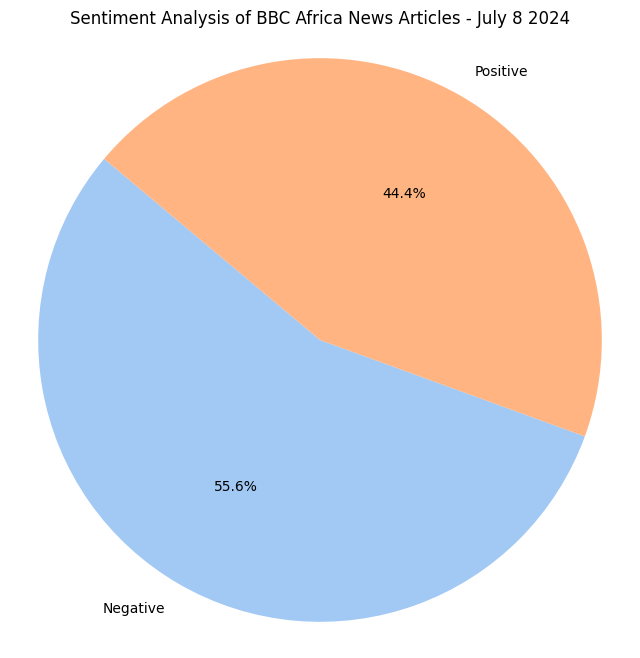

In [9]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# load the detailed CSV file
df = pd.read_csv('bbc_detailed_africa.csv')

# VADER Analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis function
def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] > 0.2:
        return 'Positive'
    elif scores['compound'] < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

df['body'] = df['body'].fillna('')    
    
# Perform sentiment analysis on each article body
df['sentiment'] = df['body'].apply(analyze_sentiment)

print("Articles and sentiment analysis results:")
print(df[['title', 'date', 'sentiment']])

# Calculate sentiment analysis result ratio
sentiment_counts = df['sentiment'].value_counts(normalize=True)

# color change
pastel_colors = sns.color_palette("pastel")

# vizualiztion pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, colors=pastel_colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Analysis of BBC Africa News Articles - July 8 2024')
plt.axis('equal')  # keep circle 
plt.show()

Countries most mentioned in articles:
Kenya       143
Ethiopia    121
Rwanda       77
Nigeria      66
Liberia      55
UK           55
Kilifi       55
Name: count, dtype: int64


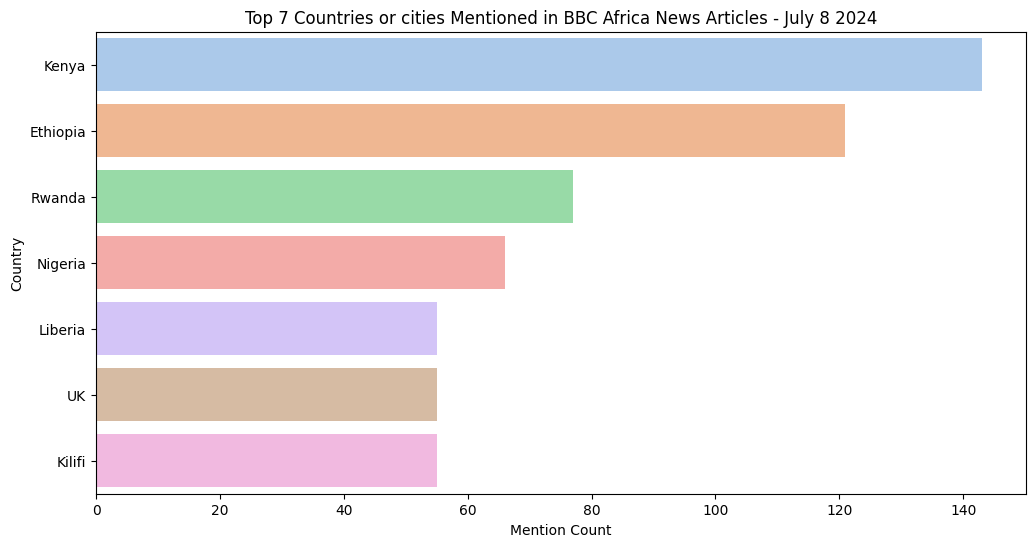

In [10]:
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# spaCy English model
nlp = spacy.load('en_core_web_sm')

# load the detailed CSV file
df = pd.read_csv('bbc_detailed_africa.csv')
df['body'] = df['body'].fillna('')

# Extract country name 
def extract_countries(text):
    doc = nlp(text)
    countries = [ent.text for ent in doc.ents if ent.label_ == 'GPE']  
    return countries

all_countries = []

for index, row in df.iterrows():
    try:
        countries = extract_countries(row['body'])
        all_countries.extend(countries)
    except Exception as e:
        print(f"Error processing article at {row['link']}: {e}")

# Ratio
country_counts = pd.Series(all_countries).value_counts()

print("Countries most mentioned in articles:")
print(country_counts.head(7))

top_countries = country_counts.head(7)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='pastel')
plt.title('Top 7 Countries or cities Mentioned in BBC Africa News Articles - July 8 2024')
plt.xlabel('Mention Count')
plt.ylabel('Country')
plt.show()

<Top 50 Most Dominant Nouns in Africa>

people: 495, Ratio: 3.05%
year: 165, Ratio: 1.02%
countries: 165, Ratio: 1.02%
land: 154, Ratio: 0.95%
president: 143, Ratio: 0.88%
state: 121, Ratio: 0.74%
government: 110, Ratio: 0.68%
years: 110, Ratio: 0.68%
family: 110, Ratio: 0.68%
divorce: 110, Ratio: 0.68%
news: 99, Ratio: 0.61%
continent: 99, Ratio: 0.61%
region: 99, Ratio: 0.61%
time: 99, Ratio: 0.61%
marriages: 99, Ratio: 0.61%
men: 88, Ratio: 0.54%
bloc: 88, Ratio: 0.54%
capital: 88, Ratio: 0.54%
women: 88, Ratio: 0.54%
music: 88, Ratio: 0.54%
number: 77, Ratio: 0.47%
power: 77, Ratio: 0.47%
police: 77, Ratio: 0.47%
life: 77, Ratio: 0.47%
protests: 77, Ratio: 0.47%
members: 77, Ratio: 0.47%
witchcraft: 77, Ratio: 0.47%
killings: 77, Ratio: 0.47%
things: 77, Ratio: 0.47%
woman: 77, Ratio: 0.47%
marriage: 77, Ratio: 0.47%
protesters: 77, Ratio: 0.47%
money: 66, Ratio: 0.41%
country: 66, Ratio: 0.41%
election: 66, Ratio: 0.41%
part: 66, Ratio: 0.41%
leaders: 66, Ratio: 0.41%
summit: 66, 

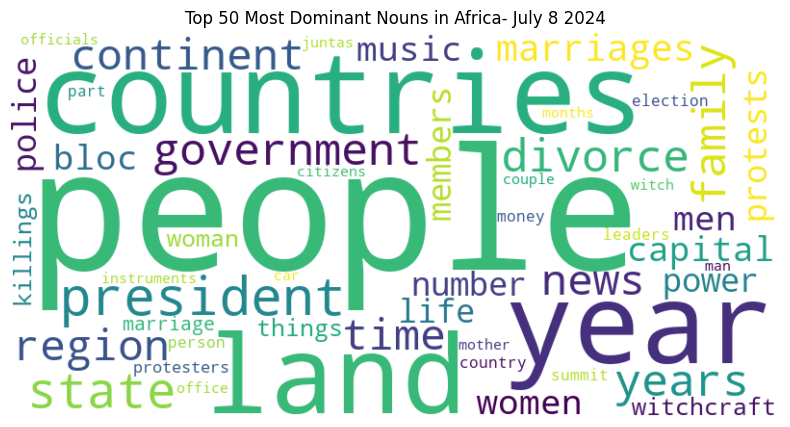

In [11]:
from collections import Counter
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# spaCy English model
nlp = spacy.load('en_core_web_sm')

# load the detailed CSV file
df = pd.read_csv('bbc_detailed_africa.csv')

# concatenate all articles
all_text = ' '.join(df['body'].dropna())

# Convert all text to spaCy object
doc = nlp(all_text)

# Extracts only nouns and includes only words with 3 or more letters
nouns = [token.text.lower() for token in doc if token.pos_ == 'NOUN' and len(token.text) >= 3]

# Word frequency calculation
word_counts = Counter(nouns)

# Ratio
total_nouns = sum(word_counts.values())
word_ratios = {word: count / total_nouns for word, count in word_counts.items()}

# Extract the top 50 most used words
most_common_words = word_counts.most_common(50)

# Rario on top 50
most_common_ratios = [(word, count, word_ratios[word]) for word, count in most_common_words]
word_freq = {word: count for word, count in most_common_words}

# Print Result
print("<Top 50 Most Dominant Nouns in Africa>")
print()
for word, count, ratio in most_common_ratios:
    print(f"{word}: {count}, Ratio: {ratio:.2%}")

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Most Dominant Nouns in Africa- July 8 2024')
plt.show()

# USA & Canada

In [23]:
# BBC URL
base_url = "https://www.bbc.com/news/us-canada"

def get_articles_from_page(url):
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract articles
    articles = soup.find_all('div', {'data-testid': 'liverpool-card'})
    news_data = []

    for article in articles:
        title_tag = article.find('h2', {'data-testid': 'card-headline'})
        link_tag = article.find('a', {'data-testid': 'internal-link'})
        date_tag = article.find('span', {'data-testid': 'card-metadata-lastupdated'})

        if title_tag and link_tag: # extract articles(url)
            title = title_tag.text.strip()
            link = "https://www.bbc.com" + link_tag['href']
            date = date_tag.text.strip() if date_tag else None
            
            news_data.append({'title': title, 'link': link, 'date': date})

    return news_data

# pagination
news_data = []
for page in range(1, 13):  # the maximum page number is 12 in the web  
    page_url = base_url + f"?page={page}"
    news_data.extend(get_articles_from_page(page_url))

# to the dataframe
df = pd.DataFrame(news_data)
df.to_csv('bbc_us-canada.csv', index=False)

print("First phase completed")

First phase completed


In [11]:
# load data from the previous CSV file
df = pd.read_csv('bbc_us-canada.csv')

# article body extracting function
def get_article_details(url):
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, 'html.parser')

    paragraphs = soup.find_all('div', {'data-component': 'text-block'})
    body = ' '.join(p.get_text(separator=' ', strip=True) for p in paragraphs)
    
    return body

# save the body
detailed_news_data = []

for index, row in df.iterrows():
    try:
        body = get_article_details(row['link'])
        detailed_news_data.append({
            'title': row['title'],
            'link': row['link'],
            'date': row['date'],
            'body': body
        })
    except Exception as e:
        print(f"Error processing article at {row['link']}: {e}")

# dataframe
detailed_df = pd.DataFrame(detailed_news_data)
detailed_df.to_csv('bbc_detailed_us-canada.csv', index=False)

print("Second phase completed")

Second phase completed


Articles and sentiment analysis results:
                                                 title         date sentiment
0    More senior Democrats privately urge Biden to ...  26 mins ago  Positive
1       Who could replace Biden as Democratic nominee?  28 mins ago  Positive
2      Can Biden be replaced as nominee? Not so easily  33 mins ago  Positive
3    Hurricane Beryl strengthens ahead of Texas lan...     1 hr ago  Negative
4    Democrats weigh risks and rewards of losing Biden   13 hrs ago  Positive
..                                                 ...          ...       ...
103  Democrats weigh risks and rewards of losing Biden   13 hrs ago  Positive
104  Project 2025: A wish list for a Trump presiden...   14 hrs ago  Positive
105                       Western US bakes in heatwave    1 day ago  Negative
106  Biden interview fails to quell Democrat concer...   2 days ago  Positive
107  Only the 'Lord Almighty' could convince me to ...   2 days ago  Positive

[108 rows x 3 columns]

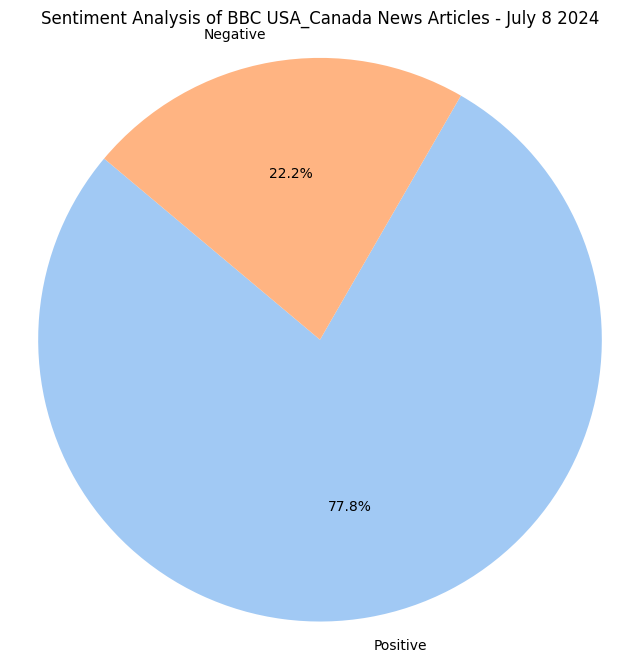

In [13]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# load the detailed CSV file
df = pd.read_csv('bbc_detailed_us-canada.csv')

# VADER Analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis function
def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] > 0.2:
        return 'Positive'
    elif scores['compound'] < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

df['body'] = df['body'].fillna('')    
    
# Perform sentiment analysis on each article body
df['sentiment'] = df['body'].apply(analyze_sentiment)

print("Articles and sentiment analysis results:")
print(df[['title', 'date', 'sentiment']])

# Calculate sentiment analysis result ratio
sentiment_counts = df['sentiment'].value_counts(normalize=True)

# color change
pastel_colors = sns.color_palette("pastel")

# vizualiztion pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, colors=pastel_colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Analysis of BBC USA_Canada News Articles - July 8 2024')
plt.axis('equal')  # keep circle 
plt.show()

Countries most mentioned in articles:
US              168
Texas           108
Houston          72
Michigan         72
California       60
Pennsylvania     60
America          48
Name: count, dtype: int64


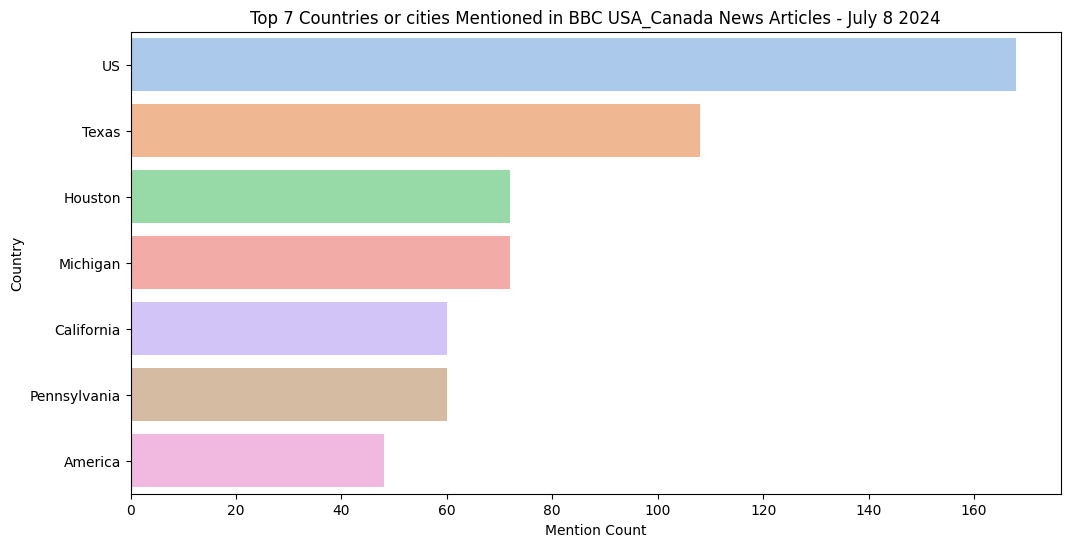

In [14]:
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# spaCy English model
nlp = spacy.load('en_core_web_sm')

# load the detailed CSV file
df = pd.read_csv('bbc_detailed_us-canada.csv')
df['body'] = df['body'].fillna('')

# Extract country name 
def extract_countries(text):
    doc = nlp(text)
    countries = [ent.text for ent in doc.ents if ent.label_ == 'GPE']  
    return countries

all_countries = []

for index, row in df.iterrows():
    try:
        countries = extract_countries(row['body'])
        all_countries.extend(countries)
    except Exception as e:
        print(f"Error processing article at {row['link']}: {e}")

# Ratio
country_counts = pd.Series(all_countries).value_counts()

print("Countries most mentioned in articles:")
print(country_counts.head(7))

top_countries = country_counts.head(7)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='pastel')
plt.title('Top 7 Countries or cities Mentioned in BBC USA_Canada News Articles - July 8 2024')
plt.xlabel('Mention Count')
plt.ylabel('Country')
plt.show()

<Top 50 Most Dominant Nouns in USA_Canada 

president: 648, Ratio: 3.69%
debate: 288, Ratio: 1.64%
party: 252, Ratio: 1.44%
campaign: 228, Ratio: 1.30%
election: 216, Ratio: 1.23%
interview: 204, Ratio: 1.16%
week: 192, Ratio: 1.09%
race: 180, Ratio: 1.03%
voters: 168, Ratio: 0.96%
state: 168, Ratio: 0.96%
candidate: 156, Ratio: 0.89%
performance: 144, Ratio: 0.82%
people: 144, Ratio: 0.82%
test: 144, Ratio: 0.82%
vice: 132, Ratio: 0.75%
term: 132, Ratio: 0.75%
candidacy: 120, Ratio: 0.68%
days: 120, Ratio: 0.68%
concerns: 108, Ratio: 0.62%
questions: 108, Ratio: 0.62%
rally: 108, Ratio: 0.62%
delegates: 108, Ratio: 0.62%
nominee: 96, Ratio: 0.55%
day: 96, Ratio: 0.55%
allies: 96, Ratio: 0.55%
number: 96, Ratio: 0.55%
ticket: 96, Ratio: 0.55%
year: 96, Ratio: 0.55%
power: 96, Ratio: 0.55%
storm: 96, Ratio: 0.55%
policy: 96, Ratio: 0.55%
process: 84, Ratio: 0.48%
presidency: 84, Ratio: 0.48%
administration: 84, Ratio: 0.48%
governor: 84, Ratio: 0.48%
supporters: 84, Ratio: 0.48%
proposa

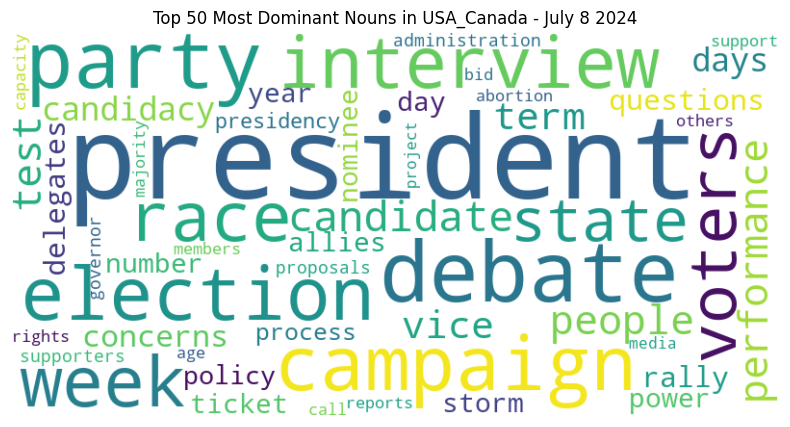

In [15]:
from collections import Counter
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# spaCy English model
nlp = spacy.load('en_core_web_sm')

# load the detailed CSV file
df = pd.read_csv('bbc_detailed_us-canada.csv')

# concatenate all articles
all_text = ' '.join(df['body'].dropna())

# Convert all text to spaCy object
doc = nlp(all_text)

# Extracts only nouns and includes only words with 3 or more letters
nouns = [token.text.lower() for token in doc if token.pos_ == 'NOUN' and len(token.text) >= 3]

# Word frequency calculation
word_counts = Counter(nouns)

# Ratio
total_nouns = sum(word_counts.values())
word_ratios = {word: count / total_nouns for word, count in word_counts.items()}

# Extract the top 50 most used words
most_common_words = word_counts.most_common(50)

# Rario on top 50
most_common_ratios = [(word, count, word_ratios[word]) for word, count in most_common_words]
word_freq = {word: count for word, count in most_common_words}

# Print Result
print("<Top 50 Most Dominant Nouns in USA_Canada ")
print()
for word, count, ratio in most_common_ratios:
    print(f"{word}: {count}, Ratio: {ratio:.2%}")

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Most Dominant Nouns in USA_Canada - July 8 2024')
plt.show()

# Top 50 Most Dominant Words in The World - July 8 2024

<Top 50 Most Dominant Nouns in The World Today>

people: 1203, Ratio: 6.36%
president: 911, Ratio: 4.82%
election: 534, Ratio: 2.83%
water: 444, Ratio: 2.35%
year: 417, Ratio: 2.21%
party: 396, Ratio: 2.10%
state: 337, Ratio: 1.78%
power: 329, Ratio: 1.74%
voters: 312, Ratio: 1.65%
women: 304, Ratio: 1.61%
debate: 288, Ratio: 1.52%
police: 269, Ratio: 1.42%
government: 254, Ratio: 1.34%
number: 233, Ratio: 1.23%
news: 231, Ratio: 1.22%
years: 230, Ratio: 1.22%
race: 228, Ratio: 1.21%
campaign: 228, Ratio: 1.21%
time: 219, Ratio: 1.16%
candidate: 216, Ratio: 1.14%
day: 216, Ratio: 1.14%
term: 216, Ratio: 1.14%
days: 204, Ratio: 1.08%
interview: 204, Ratio: 1.08%
officials: 199, Ratio: 1.05%
week: 192, Ratio: 1.02%
part: 186, Ratio: 0.98%
alliance: 168, Ratio: 0.89%
countries: 165, Ratio: 0.87%
supporters: 156, Ratio: 0.83%
land: 154, Ratio: 0.81%
members: 149, Ratio: 0.79%
right: 144, Ratio: 0.76%
media: 144, Ratio: 0.76%
performance: 144, Ratio: 0.76%
test: 144, Ratio: 0.76%
country: 1

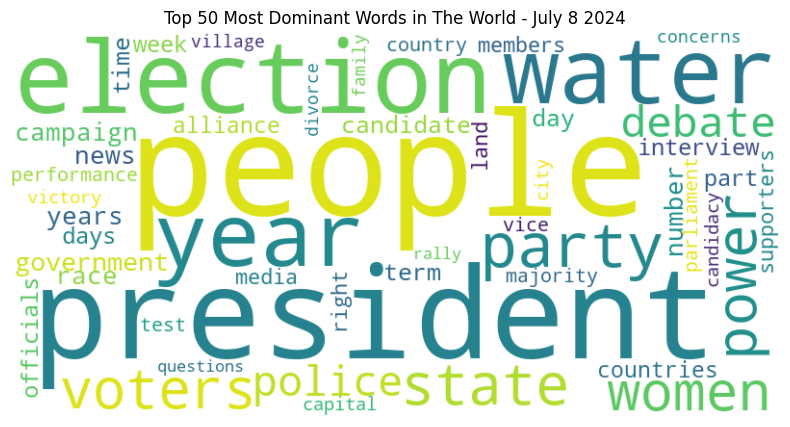

In [15]:
from wordcloud import WordCloud

# the files
files = [
    'word_analysis_bbc_europe.csv',
    'word_analysis_bbc_asia.csv',
    'word_analysis_bbc_africa.csv',
    'word_analysis_bbc_us-canada.csv'
]

# concatenate all files
dataframes = [pd.read_csv(file) for file in files]
combined_df = pd.concat(dataframes, ignore_index=True)

word_counts = Counter()
for _, row in combined_df.iterrows():
    word_counts[row['word']] += row['count']

total_nouns = sum(word_counts.values())
word_ratios = {word: count / total_nouns for word, count in word_counts.items()}
most_common_words = word_counts.most_common(50)
most_common_ratios = [(word, count, word_ratios[word]) for word, count in most_common_words]

print("<Top 50 Most Dominant Nouns in The World Today>")
print()
for word, count, ratio in most_common_ratios:
    print(f"{word}: {count}, Ratio: {ratio:.2%}")

most_common_df = pd.DataFrame(most_common_ratios, columns=['word', 'count', 'ratio'])
most_common_df.to_csv('most_common_nouns_combined.csv', index=False)

# Rario on top 50
most_common_ratios = [(word, count, word_ratios[word]) for word, count in most_common_words]
word_freq_world = {word: count for word, count in most_common_words}

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_world)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Most Dominant Words in The World - July 8 2024')
plt.show()